# MASt3R Sequence Matching Analysis

This notebook calculates normalized matching scores for a sequence of images using the MASt3R model. It evaluates feature-based and geometric matches between frames at a fixed interval (10 frames).

## 1. Environment Setup

In [19]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Set up paths
repo_root = os.getcwd()
if repo_root not in sys.path: sys.path.insert(0, repo_root)
import mast3r.utils.path_to_dust3r

from mast3r.model import AsymmetricMASt3R
from mast3r.fast_nn import extract_correspondences_nonsym, fast_reciprocal_NNs
from dust3r.inference import inference
from dust3r.image_pairs import make_pairs
from dust3r.utils.image import load_images

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 2. Load MASt3R Model

In [20]:
model_name = "MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"
model = AsymmetricMASt3R.from_pretrained(f"naver/{model_name}").to(device)
print(f"✓ Model {model_name} loaded")

✓ Model MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric loaded


## 3. Define Sequence and Parameters

In [21]:
img_dir = "/mnt/share/nas/eph/clid-dataset/davis-lightning-12-2025/Sequences/Processed/101backdoor_p0.0_extract/sequences/101backdoor_p0.0_extract/image_0/"
all_images = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
print(f"Found {len(all_images)} images")

matching_step = 10
img_size = 512
subsample = 8
total_grid_points = (img_size // subsample) * (img_size // subsample) * 2

Found 436 images


## 4. Run Matching over Sequence

In [22]:
results = []

def to_numpy_safe(tensor):
    if isinstance(tensor, torch.Tensor): return tensor.detach().cpu().numpy()
    return np.array(tensor)

frame_indices = list(range(0, len(all_images) - matching_step, matching_step))

for i in frame_indices:
    idx1, idx2 = i, i + matching_step
    path1 = os.path.join(img_dir, all_images[idx1])
    path2 = os.path.join(img_dir, all_images[idx2])
    
    # Load images and run inference
    imgs = load_images([path1, path2], size=img_size, verbose=False)
    pairs = make_pairs(imgs, scene_graph="complete", prefilter=None, symmetrize=True)
    
    with torch.no_grad():
        out = inference(pairs, model, device, batch_size=1, verbose=False)
    
    # out["pred1"] and out["pred2"] are dicts of batched tensors
    # We want the first item from each batch
    pts3d_1 = to_numpy_safe(out["pred1"]["pts3d"])[0]
    pts3d_2 = to_numpy_safe(out["pred2"]["pts3d_in_other_view"])[0]
    
    conf1 = to_numpy_safe(out["pred1"]["conf"])[0]
    conf2 = to_numpy_safe(out["pred2"]["conf"])[0]
    
    desc1 = to_numpy_safe(out["pred1"]["desc"])[0]
    desc2 = to_numpy_safe(out["pred2"]["desc"])[0]
    
    # Feature matching returns xy pairs and confidence
    feat_xy1, feat_xy2, feat_conf = extract_correspondences_nonsym(
        torch.from_numpy(desc1), torch.from_numpy(desc2),
        torch.from_numpy(conf1), torch.from_numpy(conf2)
    )
    
    # Geometric matching expects (H, W, 3) arrays
    geom_xy1, geom_xy2 = fast_reciprocal_NNs(
        torch.from_numpy(pts3d_1),
        torch.from_numpy(pts3d_2),
        subsample_or_initxy1=subsample
    )
    
    feat_score = len(feat_xy1) / total_grid_points
    geom_score = len(geom_xy1) / total_grid_points
    
    results.append({"frame": i, "feat_score": feat_score, "geom_score": geom_score})
    print(f"Processed pair ({idx1}, {idx2}): Feat={feat_score:.4f}, Geom={geom_score:.4f}")

Processed pair (0, 10): Feat=0.3073, Geom=0.3096
Processed pair (10, 20): Feat=0.3073, Geom=0.3085
Processed pair (20, 30): Feat=0.3068, Geom=0.3092
Processed pair (30, 40): Feat=0.3069, Geom=0.3094
Processed pair (40, 50): Feat=0.3073, Geom=0.3088
Processed pair (50, 60): Feat=0.6133, Geom=0.3103
Processed pair (60, 70): Feat=0.5493, Geom=0.2780
Processed pair (70, 80): Feat=0.6240, Geom=0.3104
Processed pair (80, 90): Feat=0.5536, Geom=0.3049
Processed pair (90, 100): Feat=0.5161, Geom=0.2920
Processed pair (100, 110): Feat=0.5072, Geom=0.2946
Processed pair (110, 120): Feat=0.5139, Geom=0.2885
Processed pair (120, 130): Feat=0.5116, Geom=0.2871
Processed pair (130, 140): Feat=0.5048, Geom=0.2819
Processed pair (140, 150): Feat=0.5155, Geom=0.2834
Processed pair (150, 160): Feat=0.5425, Geom=0.2795
Processed pair (160, 170): Feat=0.5504, Geom=0.2913
Processed pair (170, 180): Feat=0.2449, Geom=0.1221
Processed pair (180, 190): Feat=0.4402, Geom=0.2413
Processed pair (190, 200): Feat=

## 5. Plotting Results

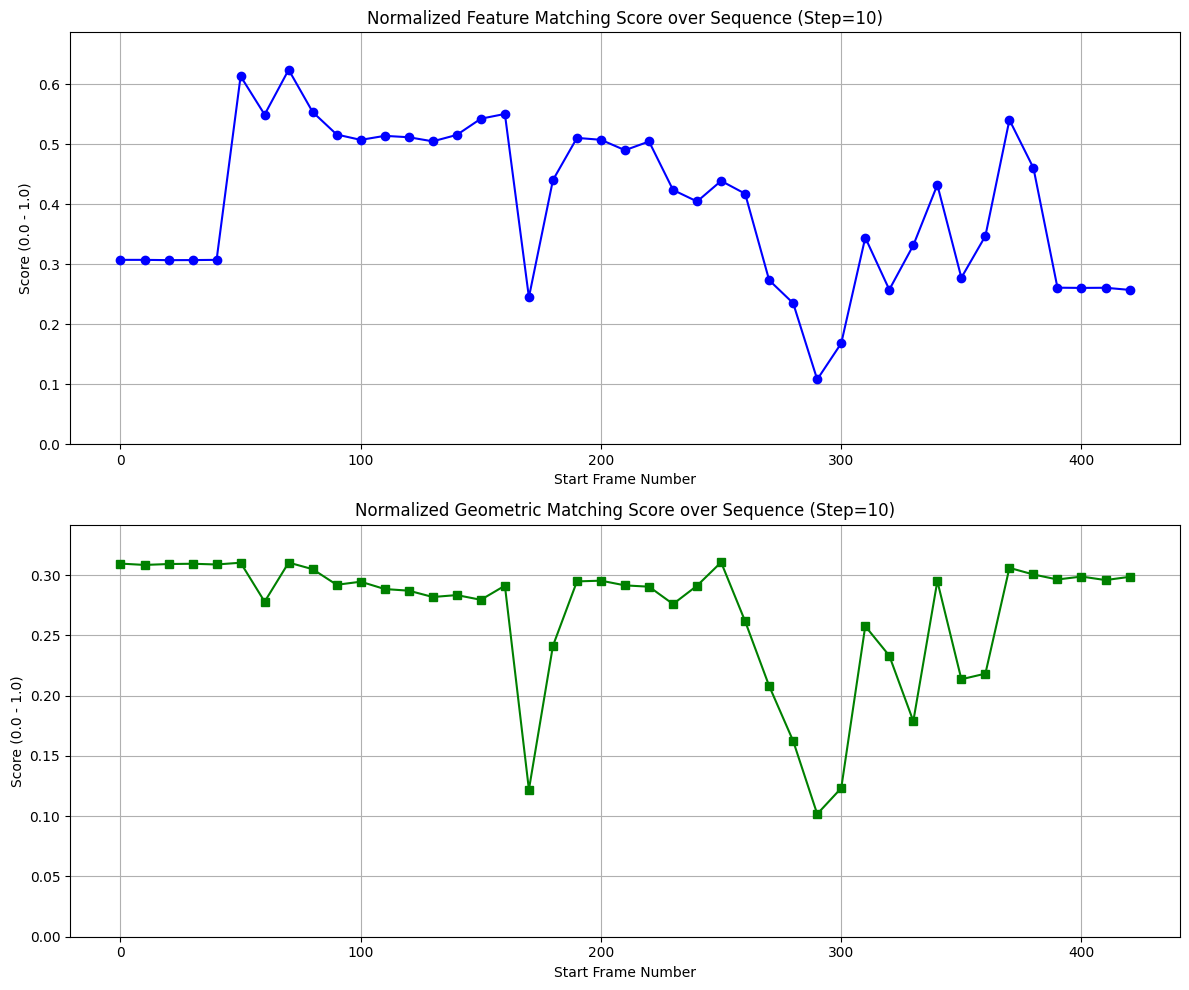

In [23]:
frames = [r["frame"] for r in results]
feat_scores = [r["feat_score"] for r in results]
geom_scores = [r["geom_score"] for r in results]

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(frames, feat_scores, marker="o", linestyle="-", color="blue")
plt.title("Normalized Feature Matching Score over Sequence (Step=10)")
plt.xlabel("Start Frame Number")
plt.ylabel("Score (0.0 - 1.0)")
plt.grid(True)
if feat_scores: plt.ylim(0, max(feat_scores) * 1.1)

plt.subplot(2, 1, 2)
plt.plot(frames, geom_scores, marker="s", linestyle="-", color="green")
plt.title("Normalized Geometric Matching Score over Sequence (Step=10)")
plt.xlabel("Start Frame Number")
plt.ylabel("Score (0.0 - 1.0)")
plt.grid(True)
if geom_scores: plt.ylim(0, max(geom_scores) * 1.1)

plt.tight_layout()
plt.show()

## 6. Summary Statistics

In [24]:
import numpy as np

# Compute mean and std directly from results for robustness
feat_vals = np.array([r["feat_score"] for r in results], dtype=float)
geom_vals = np.array([r["geom_score"] for r in results], dtype=float)

def safe_stats(arr):
    if arr.size == 0:
        return float('nan'), float('nan')
    return float(np.mean(arr)), float(np.std(arr))

feat_mean, feat_std = safe_stats(feat_vals)
geom_mean, geom_std = safe_stats(geom_vals)

print(f"Feature score: mean={feat_mean:.4f}, std={feat_std:.4f}")
print(f"Geometric score: mean={geom_mean:.4f}, std={geom_std:.4f}")

Feature score: mean=0.4008, std=0.1280
Geometric score: mean=0.2677, std=0.0546
